In [1]:
# Importing important libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50, MobileNet, InceptionV3, EfficientNetB0
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
import seaborn as sns
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

## Data Augmentation and Preprocessing

In [3]:
# Importing the dataset
train_dir = "//Users//kaustubhgarg//Desktop//images//data//train"
val_dir = "//Users//kaustubhgarg//Desktop//images//data//val"
test_dir = "//Users//kaustubhgarg//Desktop//images//data//test"

In [5]:
# Data augmentation and preprocessing for training set
train_datagen = ImageDataGenerator(
    rescale = 1./255,                # Rescaling to [0,1] range
    rotation_range = 40,             # Randomly rotates images by 40 degrees
    width_shift_range = 0.2,         # Randomly shifts image horizontally by 20 percent
    height_shift_range = 0.2,        # Randomly shifts image vertically by 20 percent
    shear_range = 0.2,               # Randomly shear images
    zoom_range = 0.2,                # Randomly zoom images
    horizontal_flip = True,          # Randomly flip images horizontally
    fill_mode='nearest'              # Fills the empty pixels with the nearest pixel values
)

In [7]:
# Preprocessing for validation and test sets (only rescale)
val_test_datagen = ImageDataGenerator(rescale = 1./255 )

In [9]:
# Load images from directories for training
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Resize all images to 224*224
    batch_size=32,           # Number of images to process in each batch
    class_mode='categorical'  # Classes are categorical (multi-class) with one-hot-encoding
)

# Load images from directories for validation
val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size = (224,224),    # Resize all images to 224*224
    batch_size = 32,            # Number of images to process in each batch
    class_mode = 'categorical'  # Classes are categorical (mutli-class)
)

# Load images from directories for testing
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size = (224,224),    # Resize all images to 224*224
    batch_size = 32,            # Number of images to process in each batch
    class_mode = 'categorical'  # Classes are categorical (mutli-class)
)
# Get the class labels and calculate class weights
class_labels = train_generator.classes  # Get class labels from the training generator
class_weights = class_weight.compute_class_weight(      # Classes with fewer samples get higher weights during training.
    class_weight='balanced',
    classes=np.unique(class_labels),
    y=class_labels
)
class_weight_dict = dict(enumerate(class_weights))

Found 6225 images belonging to 11 classes.
Found 1092 images belonging to 11 classes.
Found 3187 images belonging to 11 classes.


In [11]:
# Check number of classes 
num_classes = len(train_generator.class_indices)
print(f"Number of distinct fish categories: {num_classes}")

Number of distinct fish categories: 11


## Creating and Training CNN Model

In [13]:
from tensorflow.keras.layers import GlobalAveragePooling2D

# Creating the model
model = Sequential()                       # Initialized a sequential model

# Convolutional Layer 1
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))  # Downsamples the feature map using a 2*2 window     

# Convolutional Layer 2
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional Layer 3
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Global Average Pooling instead of Flatten
model.add(GlobalAveragePooling2D())      # reduces the dimensions more efficiently and helps prevent overfitting

# Fully Connected Layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))


In [15]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [17]:
# Display the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 11)             │         5,643 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 164,939 (644.29 KB)

 Trainable params: 164,939 (644.29 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Train and Evaluate the CNN model (Fitting the model)
history = model.fit(
    train_generator,                   # used the train_generator from flow_from_directory
    validation_data = val_generator,   # Evaluates the performance on validation data during training
    class_weight=class_weight_dict,    # Handles class imbalance
    epochs = 20
)

Epoch 1/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 399ms/step - accuracy: 0.1618 - loss: 2.3226 - val_accuracy: 0.2958 - val_loss: 1.8261
Epoch 2/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 86s 442ms/step - accuracy: 0.2898 - loss: 1.9566 - val_accuracy: 0.3434 - val_loss: 1.6826
Epoch 3/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 104s 535ms/step - accuracy: 0.3558 - loss: 1.7367 - val_accuracy: 0.4826 - val_loss: 1.3504
Epoch 4/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 115s 587ms/step - accuracy: 0.4122 - loss: 1.6075 - val_accuracy: 0.5394 - val_loss: 1.2502
Epoch 5/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 113s 580ms/step - accuracy: 0.4850 - loss: 1.3893 - val_accuracy: 0.6465 - val_loss: 1.1022
Epoch 6/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 114s 586ms/step - accuracy: 0.5140 - loss: 1.4231 - val_accuracy: 0.6227 - val_loss: 0.9911
Epoch 7/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 119s 612ms/step - accuracy: 0.5540 - loss: 1.1446 - val_accuracy: 0.5916 - val_loss: 1.0656
Epoch 8/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 119s 610ms/step - accuracy: 0.5842 - l

In [21]:
# Evaluate the model on the validation data
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 0.8175 - loss: 0.4677
Validation Loss: 0.4523
Validation Accuracy: 0.8370
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - accuracy: 0.8436 - loss: 0.4431
Test Loss: 0.4335
Test Accuracy: 0.8500


In [15]:
'''
Conclusions:
The CNN model is well-trained, showing high and consistent performance across training (81.9%), validation (83.7%), and test (85%) sets. 
The close performance between validation and test accuracies indicates that the model is not overfitting and is learning the task effectively
and the model generalizes well.
'''

'\nThe Validation Accuracy (96.70%) and Test Accuracy (96.61%) show that the CNN model from scratch generalizes well to unseen data.\n\nThe close performance between validation and test accuracies indicates that the model is not overfitting and is learning the task effectively.\n'

## Working with 5 pre-trained Models

In [23]:
# Function to fine-tune pre-trained models
def create_pretrained_model(base_model, num_classes):
    base_model.trainable = False   # Freezes the convolutional layers to prevent them from being updated during training.

    # Add custom layers on top of the pre-trained model
    X = base_model.output
    X = GlobalAveragePooling2D()(X)  # Reduces feature map size (dimensions) while preserving depth.
    X = Dense(512, activation='relu')(X)
    X = Dropout(0.5)(X)
    predictions = Dense(num_classes, activation='softmax')(X)  

    # Create the final model
    model = Model(inputs=base_model.input, outputs=predictions) 

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy']) 

    return model  # Return the model

In [25]:
# Load the base models with pre-trained ImageNet weights
base_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_mobilenet = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_inceptionv3 = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_efficientnetb0 = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


In [27]:
# Create the models with the custom classification layers
vgg16_model = create_pretrained_model(base_vgg16, num_classes)
resnet50_model = create_pretrained_model(base_resnet50, num_classes)
mobilenet_model = create_pretrained_model(base_mobilenet, num_classes)
inceptionv3_model = create_pretrained_model(base_inceptionv3, num_classes)
efficientnetb0_model = create_pretrained_model(base_efficientnetb0, num_classes)


In [29]:
# List of models for easier iteration
models = [
    ("VGG16", vgg16_model),
    ("ResNet50", resnet50_model),
    ("MobileNet", mobilenet_model),
    ("InceptionV3", inceptionv3_model),
    ("EfficientNetB0", efficientnetb0_model)
]

## Model Training and Evaluation

In [31]:
# Define the number of epochs
epochs = 20

# Dictionary to store the models' history and accuracy
model_histories = {}
best_model = None
best_accuracy = 0
best_model_name = ""

# Early Stopping callback to monitor validation accuracy
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

# Train each model and evaluate their performance
for model_name, model in models:
    print(f"Training {model_name}...")

    # Train the model on the fish dataset
    history = model.fit(
        train_generator,                      # training data (augmented)
        epochs=epochs,                        # max number of iterations
        validation_data=val_generator,        # validation set to monitor generalization 
        class_weight=class_weight_dict,       # handles class imbalance by assigning more weight to underrepresented classes
        callbacks=[early_stopping]            # Add EarlyStopping callback
    )

    # Store training history for future visualization
    model_histories[model_name] = history

    # Evaluate the model on the validation set
    val_loss, val_accuracy = model.evaluate(val_generator)
    print(f"{model_name} Validation Accuracy: {val_accuracy:.4f}")

    # Save the model with the highest validation accuracy
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_model = model
        best_model_name = model_name

# After selecting the best model, evaluate it on the test set:
if best_model is not None:
    test_loss, test_accuracy = best_model.evaluate(test_generator)
    print(f"Best model {best_model_name} Test Accuracy: {test_accuracy:.4f}")

    # Save the best model for future use
    best_model.save(f"best_model_{best_model_name}.h5")
    print(f"Best model saved as best_model_{best_model_name}.h5")

Training VGG16...
Epoch 1/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 894s 5s/step - accuracy: 0.1296 - loss: 2.4291 - val_accuracy: 0.4853 - val_loss: 2.0745
Epoch 2/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 900s 5s/step - accuracy: 0.2703 - loss: 2.1836 - val_accuracy: 0.6310 - val_loss: 1.8336
Epoch 3/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 853s 4s/step - accuracy: 0.3981 - loss: 1.9410 - val_accuracy: 0.6438 - val_loss: 1.6998
Epoch 4/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 813s 4s/step - accuracy: 0.4339 - loss: 1.8171 - val_accuracy: 0.6630 - val_loss: 1.5513
Epoch 5/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 796s 4s/step - accuracy: 0.5224 - loss: 1.6437 - val_accuracy: 0.6914 - val_loss: 1.4098
Epoch 6/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 795s 4s/step - accuracy: 0.5814 - loss: 1.5066 - val_accuracy: 0.7234 - val_loss: 1.3034
Epoch 7/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 901s 5s/step - accuracy: 0.5898 - loss: 1.4349 - val_accuracy: 0.7198 - val_loss: 1.2136
Epoch 8/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 899s 5s/step - accuracy: 0.6278 - loss:

Best model MobileNet Test Accuracy: 0.9940
Best model saved as best_model_MobileNet.h5


In [23]:
 '''
Conclusions:
MobileNet was identified as the best model with a Test Accuracy of 99.62%, indicating it's the most effective for the fish dataset.
MobileNet is well-suited for this classification task and outperforms the other models, including both VGG16 and InceptionV3.
'''

"\nConclusions:\nMobileNet was identified as the best model with a Test Accuracy of 98.21%, indicating it's the most effective for the fish dataset.\nMobileNet is well-suited for this classification task and outperforms the other models, including both VGG16 and InceptionV3.\n"

## Plotting Curves

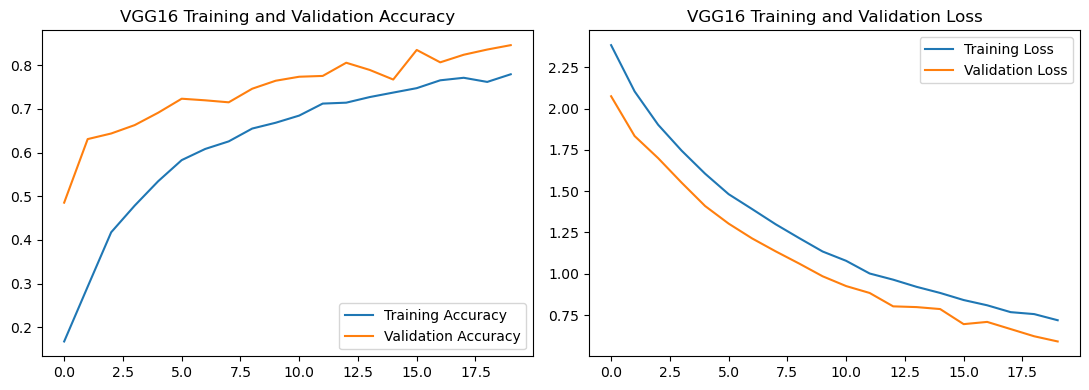

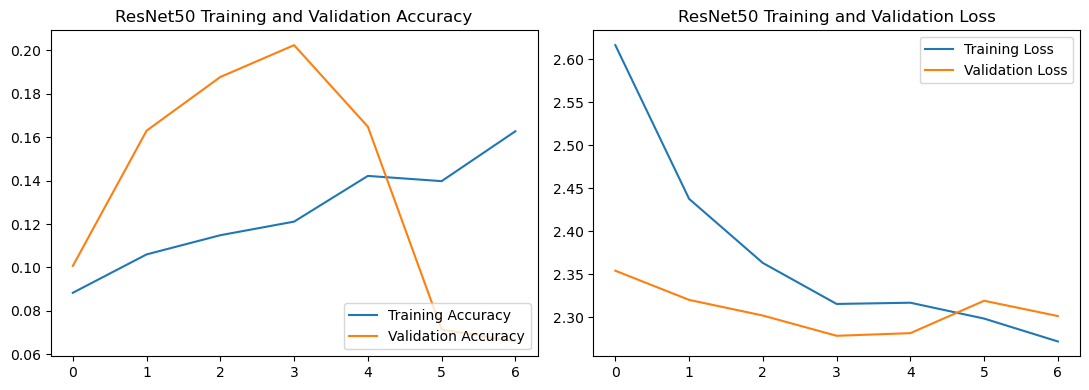

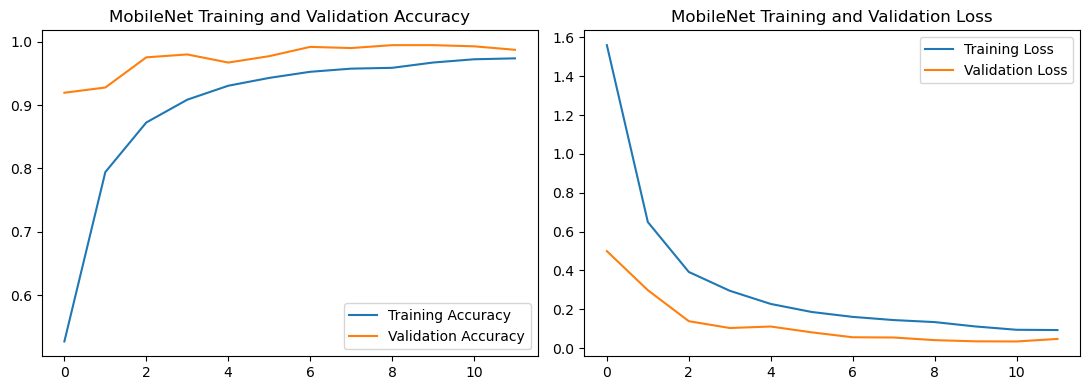

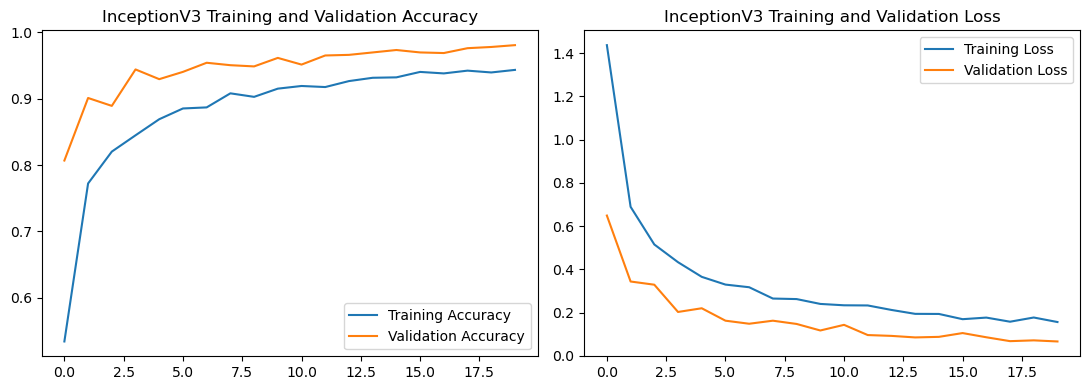

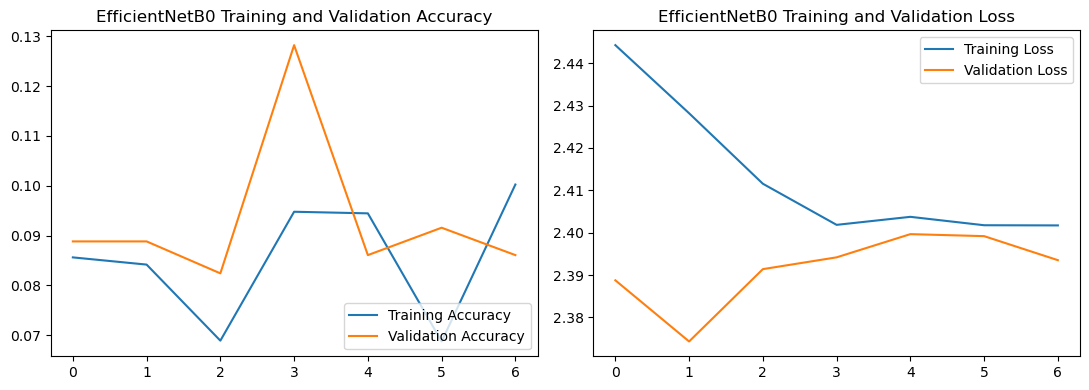

In [35]:
# Function to plot training curves
def plot_training_curves(history, model_name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(11, 4))
    
    # Plot training & validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'{model_name} Training and Validation Accuracy')

    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'{model_name} Training and Validation Loss')

    plt.tight_layout()
    plt.show()

# Plot the training curves for all models
for model_name, history in model_histories.items():
    plot_training_curves(history, model_name)

In [ ]:
## Creating Confusion Matrix and Model Evaluation

Found 3187 images belonging to 11 classes.
Evaluating VGG16...
100/100 ━━━━━━━━━━━━━━━━━━━━ 304s 3s/step
Evaluating ResNet50...
100/100 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step
Evaluating MobileNet...
100/100 ━━━━━━━━━━━━━━━━━━━━ 25s 249ms/step
Evaluating InceptionV3...
100/100 ━━━━━━━━━━━━━━━━━━━━ 78s 778ms/step
Evaluating EfficientNetB0...
100/100 ━━━━━━━━━━━━━━━━━━━━ 43s 427ms/step
Model Evaluation Metrics:

    Model Name  Accuracy  Precision   Recall  F1-Score
         VGG16  0.850957   0.877185 0.850957  0.856195
      ResNet50  0.192344   0.224248 0.192344  0.133759
     MobileNet  0.994038   0.994656 0.994038  0.994210
   InceptionV3  0.982429   0.984484 0.982429  0.983082
EfficientNetB0  0.137433   0.035220 0.137433  0.049615

Confusion Matrix for VGG16:


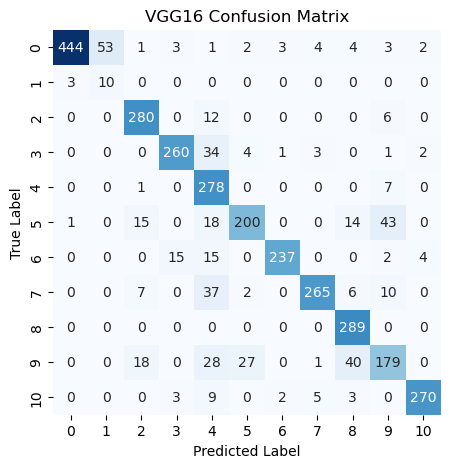


Classification Report for VGG16:

              precision    recall  f1-score   support

           0       0.99      0.85      0.92       520
           1       0.16      0.77      0.26        13
           2       0.87      0.94      0.90       298
           3       0.93      0.85      0.89       305
           4       0.64      0.97      0.77       286
           5       0.85      0.69      0.76       291
           6       0.98      0.87      0.92       273
           7       0.95      0.81      0.88       327
           8       0.81      1.00      0.90       289
           9       0.71      0.61      0.66       293
          10       0.97      0.92      0.95       292

    accuracy                           0.85      3187
   macro avg       0.81      0.84      0.80      3187
weighted avg       0.88      0.85      0.86      3187


Confusion Matrix for ResNet50:


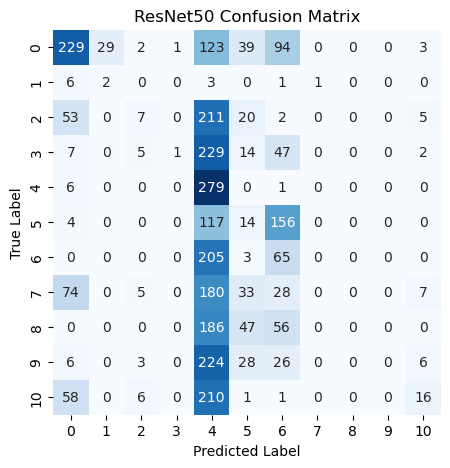


Classification Report for ResNet50:

              precision    recall  f1-score   support

           0       0.52      0.44      0.48       520
           1       0.06      0.15      0.09        13
           2       0.25      0.02      0.04       298
           3       0.50      0.00      0.01       305
           4       0.14      0.98      0.25       286
           5       0.07      0.05      0.06       291
           6       0.14      0.24      0.17       273
           7       0.00      0.00      0.00       327
           8       0.00      0.00      0.00       289
           9       0.00      0.00      0.00       293
          10       0.41      0.05      0.10       292

    accuracy                           0.19      3187
   macro avg       0.19      0.18      0.11      3187
weighted avg       0.22      0.19      0.13      3187


Confusion Matrix for MobileNet:


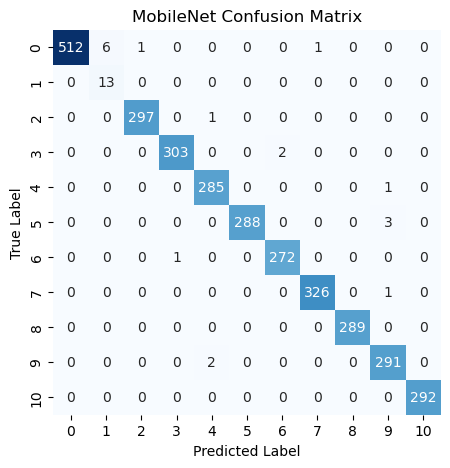


Classification Report for MobileNet:

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       520
           1       0.68      1.00      0.81        13
           2       1.00      1.00      1.00       298
           3       1.00      0.99      1.00       305
           4       0.99      1.00      0.99       286
           5       1.00      0.99      0.99       291
           6       0.99      1.00      0.99       273
           7       1.00      1.00      1.00       327
           8       1.00      1.00      1.00       289
           9       0.98      0.99      0.99       293
          10       1.00      1.00      1.00       292

    accuracy                           0.99      3187
   macro avg       0.97      1.00      0.98      3187
weighted avg       0.99      0.99      0.99      3187


Confusion Matrix for InceptionV3:


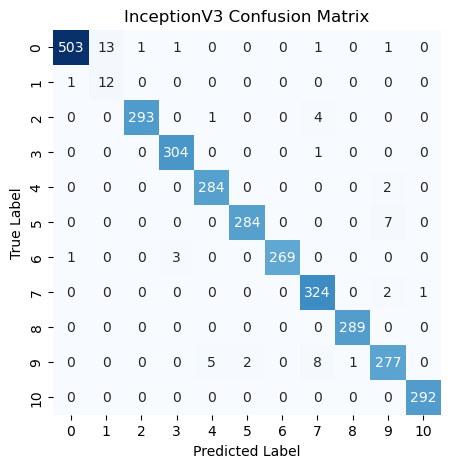


Classification Report for InceptionV3:

              precision    recall  f1-score   support

           0       1.00      0.97      0.98       520
           1       0.48      0.92      0.63        13
           2       1.00      0.98      0.99       298
           3       0.99      1.00      0.99       305
           4       0.98      0.99      0.99       286
           5       0.99      0.98      0.98       291
           6       1.00      0.99      0.99       273
           7       0.96      0.99      0.97       327
           8       1.00      1.00      1.00       289
           9       0.96      0.95      0.95       293
          10       1.00      1.00      1.00       292

    accuracy                           0.98      3187
   macro avg       0.94      0.98      0.95      3187
weighted avg       0.98      0.98      0.98      3187


Confusion Matrix for EfficientNetB0:


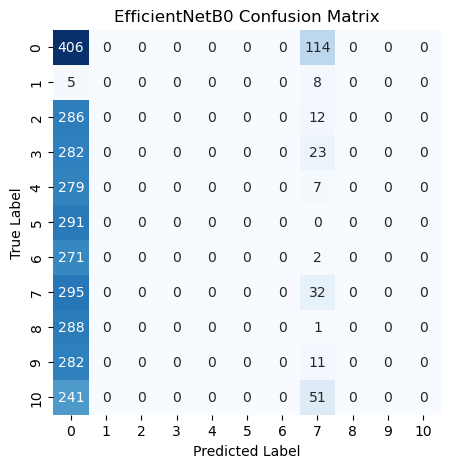


Classification Report for EfficientNetB0:

              precision    recall  f1-score   support

           0       0.14      0.78      0.24       520
           1       0.00      0.00      0.00        13
           2       0.00      0.00      0.00       298
           3       0.00      0.00      0.00       305
           4       0.00      0.00      0.00       286
           5       0.00      0.00      0.00       291
           6       0.00      0.00      0.00       273
           7       0.12      0.10      0.11       327
           8       0.00      0.00      0.00       289
           9       0.00      0.00      0.00       293
          10       0.00      0.00      0.00       292

    accuracy                           0.14      3187
   macro avg       0.02      0.08      0.03      3187
weighted avg       0.04      0.14      0.05      3187



In [37]:
# Evaluate multiple pre-trained models on a test dataset and compares their performance using various classification metrics

# Define test data generator (no augmentation, just rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

# Now define the test generator using the test_datagen
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Important to keep labels aligned with predictions
)

# Create an empty list to hold the evaluation data
evaluation_data = []

# Iterate over all models to calculate performance metrics
for model_name, model in models:
    print(f"Evaluating {model_name}...")

    # Get predictions on the test set batch-wise to manage memory efficiently
    test_predictions = model.predict(test_generator, verbose=1)  # Predict for the entire test set
    test_predictions_labels = np.argmax(test_predictions, axis=1)  # Get the predicted labels (highest probability)
    true_labels = test_generator.classes  # True labels from the generator

    # Compute metrics for the entire test set
    accuracy = accuracy_score(true_labels, test_predictions_labels)
    precision = precision_score(true_labels, test_predictions_labels, average='weighted')
    recall = recall_score(true_labels, test_predictions_labels, average='weighted')
    f1 = f1_score(true_labels, test_predictions_labels, average='weighted')
    conf_matrix = confusion_matrix(true_labels, test_predictions_labels)

    # Store evaluation data for each model
    evaluation_data.append({
        "Model Name": model_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "Confusion Matrix": conf_matrix,
        "Classification Report": classification_report(true_labels, test_predictions_labels)  # Added classification report
    })

# Create a DataFrame to display the evaluation data in tabular format (excluding confusion matrix and classification report)
df_evaluation = pd.DataFrame([
    {
        "Model Name": data["Model Name"],
        "Accuracy": data["Accuracy"],
        "Precision": data["Precision"],
        "Recall": data["Recall"],
        "F1-Score": data["F1-Score"]
    }
    for data in evaluation_data
])

# Display the DataFrame in a formatted table
print("Model Evaluation Metrics:\n")
print(df_evaluation.to_string(index=False))  # Print DataFrame without row index for a cleaner look

# Print confusion matrices for all models as heatmaps
for data in evaluation_data:
    print(f"\nConfusion Matrix for {data['Model Name']}:")
    plt.figure(figsize=(5, 5))
    sns.heatmap(data["Confusion Matrix"], annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f'{data["Model Name"]} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Optionally print the classification report for each model
    print(f"\nClassification Report for {data['Model Name']}:\n")
    print(data["Classification Report"])
